# Model Pipeline

## Initial data and folder structure.

It is important to ensure that the initial files are organized in a consistent structure.
The original training dataset `dynamic-rhythms-train-data`, provided by the contest, must be placed inside the raw data directory. Additionally, the meteorological data will be generated and stored by us in the same section. 

Here is the initial data expected folder structure (as seen from the root directory of the project):
```

dynamic-rythms/
│
├── data/
│   ├── external/                # Data from third-party sources.
│   ├── interim/                 # Intermediate data files.
│   └── raw/                     # Original, immutable data
│       ├── dynamic-rhythms-train-data/ # Provided by the contest
│       │   └── data/
│       │       ├── eaglei_data/
│       │       └── NOAA_StormEvents/
│       └── meteorological/      # API-generated storm condition data.
```


## Data Gathering.

To build a reliable dataset for storm-driven outage prediction, we implemented a multi-step data gathering processing strategy that integrates 
- outage reports
- storm episode records
- geospatial county data
- and hourly meteorological conditions

Our goal was to download and merge all the provided data focused exclusively on high-impact events, with clear storm-outage relationships and rich contextual information. The following sections outline each stage of the data preparation pipeline, from filtering relevant outages to generating API calls for weather data—forming the foundation of the predictive modeling framework.

![](../assets/images/initial-data-pipeline.png)

- a) **Outage Information**: We use the outage data. To ensure we focus on impactful events, we define a relevance threshold based on the number of people affected. Specifically, we only consider outages that impacted more than $10^{3.5}$, which corresponds to approximately $3162$ people. This allows us to filter out minor incidents and concentrate on events with significant societal impact. Additionally, we group nearby outage reports that occurred within a defined time frame and affected the same  neighboring counties. This allowed us to treat such cases as a single, prolonged event rather than multiple isolated incidents.

- b) **Storm Information**: We organized storm data at an *episode level*, grouping together related storm events that occurred within a single system. For each storm episode, we defined a start and end date to establish its duration. Recognizing that large storms can impact multiple counties simultaneously, we created a composite identifier by combining the storm episode ID with the county FIPS code. This new field, episode_fips_id, uniquely represents the intersection between a specific storm and a specific county, allowing us to track localized impacts of broader storm systems.

- c) **County Information**: We obtained official county boundaries from the U.S. Census Bureau using the  shapefile in this [link](https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_county_5m.zip). This shapefile provides precise geospatial data for all U.S. counties. We use this information to provide our meteorological API requests with accurate geographic points. 

- d) **Outage + Storm**: To associate outages with specific storm events, we merged storm and outage data based on temporal proximity. While we acknowledge this is a simplification, it provides a useful approximation for identifying likely storm-related outages. Specifically, we considered an outage to be linked to a storm if it occurred during the storm episode (covering case 1 and case 2) or within one day after its end (case 3). This rule allows us to flag storms that likely caused disruptions, and to distinguish them from those that passed without triggering significant outages. This cases are shown in the following figure:

![](../assets/images/outage_cases.png)

- e) **Defining the dataset scope**: At first instance, we narrowed our focus to include only storm episodes that were linked to at least one outage. This filtered set forms the foundation of our training dataset, ensuring that the model is initially trained on events with known impacts. By starting with confirmed storm-outage associations, we simplify the problem space and prioritize learning from patterns with clear outcomes, which will help refine and scale the model in future iterations (which are outside this scope).

- f-g) **API Calls**: We then generate a Dataframe containing information of the storms that resulted in at least one outage, merged with the county dataset. Since we have access to both storm and outage durations, we define a temporal window that spans from one day before to one day after each storm. This window allows us to later request hourly meteorological data relevant to each storm's lifecycle. To represent the geographic location of each county, we use its centroid coordinates (latitude and longitude), as pinpointing the exact affected city within a county is not always feasible. With the combination of the `episode_fips_id`, county centroid location and the defined date-time window, we are able to generate the corresponding API calls in batch, retrieving the meteorological conditions that potentially led to the observed outages. API calls are made with the [Power project](https://power.larc.nasa.gov/). The result of each API call is a JSON file containing detailed hourly meteorological conditions within the defined temporal window. Each JSON file is named using the corresponding episode_fips_id, enabling easy traceability and alignment with the original storm-outage pair. These files will later be parsed and transformed into structured features for the machine learning model.
-------------


### Meteorological Variables 

<div style="display: flex; align-items: center;">
  <img src="../assets/images/icons/METEOROLOGICAL_DATA.png" alt="Meteorological Data" width="200" style="margin-right: 20px;"/>

  <p>
    To enrich our dataset with real-world weather conditions surrounding each storm episode, we incorporated hourly meteorological data retrieved through the NASA POWER Project. The variables selected capture a wide range of atmospheric and environmental factors critical for understanding storm dynamics and their potential to cause outages. Importantly, all meteorological features retrieved are Near Real-Time (NRT) products, meaning they are updated frequently and available soon after the observations are made. This characteristic allows the project not only to model historical storm impacts but also to set the foundation for real-time model evaluation and deployment in production environments, enabling proactive outage prediction based on incoming meteorological conditions.
  </p>
</div>

The following table contains all the meteorological variables that where fetched through the API.

| Variable                | Description                                                                                      | Units               | NRT Available |
|--------------------------|--------------------------------------------------------------------------------------------------|---------------------|---------------|
| T10M                     | Average air (dry bulb) temperature at 10 meters above surface.                                   | °C                  | ✅             |
| ALLSKY_SFC_SW_DWN         | Total solar irradiance on a horizontal surface under all sky conditions.                        | Wh/m²               | ✅             |
| PS                       | Surface atmospheric pressure.                                                                  | kPa                 | ✅             |
| WS50M                    | Average wind speed at 50 meters above surface.                                                  | m/s                 | ✅             |
| ALLSKY_SFC_LW_DWN         | Downward thermal infrared irradiance under all sky conditions at the surface.                   | Wh/m²               | ✅             |
| WD50M                    | Average wind direction at 50 meters above surface.                                              | Degrees             | ✅             |
| PRECTOTCORR               | Bias-corrected total precipitation at surface.                                                  | mm/hour             | ✅             |
| GWETPROF                 | Soil moisture profile (surface to bedrock), 0 (dry) to 1 (saturated).                           | Fraction (0–1)      | ✅             |
| CLRSKY_SFC_SW_DWN         | Total solar irradiance on a horizontal surface under clear sky conditions.                     | Wh/m²               | ✅             |
| QV10M                    | Specific humidity at 10 meters (mass of water vapor per mass of air).                           | g/kg                | ✅             |
| RHOA                     | Surface air density.                                                                            | kg/m³               | ✅             |
| TO3                      | Total atmospheric ozone concentration from surface to top of atmosphere.                       | Dobson Units        | ✅             |
| TQV                      | Total column atmospheric water vapor content.                                                   | kg/m²               | ✅             |
| Z0M                      | Surface roughness length (height where mean wind speed becomes zero).                           | meters              | ✅             |
| TOA_SW_DWN               | Total solar irradiance at the top of the atmosphere.                                             | Wh/m²               | ✅             |
| RH2M                     | Relative humidity at 2 meters above surface.                                                    | %                   | ✅             |
| WS2M                     | Average wind speed at 2 meters above surface.                                                    | m/s                 | ✅             |
| CLRSKY_SFC_LW_DWN         | Downward thermal infrared irradiance under clear sky conditions at the surface.                 | Wh/m²               | ✅             |
| DISPH                    | Displacement height due to large obstacles (e.g., trees, buildings).                            | meters              | ✅             |



----
To execute the data gathering process, we need to run the following scripts:
- src/downloader.py
- src/cleaner.py
- src/storm_outages.py
- src/meteorological_api.py

When the scripts are run for the first time, the complete data gathering pipeline is executed. This includes downloading the necessary files, cleaning the data, merging storm and outage records, and retrieving meteorological information. Once the data has been successfully processed and stored, these steps are skipped in subsequent runs to avoid redundant computations.

In [1]:
import src.downloader as downloader
import src.cleaner as cleaner
import src.storm_outages as storm_outages
import src.meteorological_api as meteorological_api

In [2]:
%%time
downloader.download()

Info already exists...
Information is already saved at: /mnt/c/Users/52333/Documents/projects/dynamic-rythms/src/../data/external/county.parquet
CPU times: user 2.76 ms, sys: 908 μs, total: 3.67 ms
Wall time: 22.3 ms


In [3]:
%%time
cleaner.execute()

File already exists, it is located at: /mnt/c/Users/52333/Documents/projects/dynamic-rythms/src/../data/interim/storm_events_cleaned.csv
CPU times: user 725 μs, sys: 239 μs, total: 964 μs
Wall time: 5.49 ms


In [4]:
%%time
storm_outages.execute()

File already exists, it is located at: /mnt/c/Users/52333/Documents/projects/dynamic-rythms/src/../data/interim/storm_outages_2014_2023.parquet
CPU times: user 0 ns, sys: 1.28 ms, total: 1.28 ms
Wall time: 6.34 ms


In [5]:
%%time
meteorological_api.download_process()

API calls are turned off. If you know what you are doing, change the API_CALLS_ON parameter on the script. Otherwise, information might already be existing at /mnt/c/Users/52333/Documents/projects/dynamic-rythms/src/../data/raw/meteorological
Checking if meteorological information is downloaded...
Meteorological data exists at /mnt/c/Users/52333/Documents/projects/dynamic-rythms/src/../data/raw/meteorological
CPU times: user 0 ns, sys: 703 μs, total: 703 μs
Wall time: 3.98 ms


## Dataset Handling

Once all the data has been gathered, we can begin constructing the foundational dataset for modeling. In this context, a storm is represented as a sequence of meteorological conditions over time. The central question the dataset is designed to answer is:
"Given the current weather conditions, will an outage occur in the next hour?"

To generate the response variable, we compare the timestamp of each meteorological observation with the recorded outage start times. Additionally, we engineer new features to better capture the underlying dynamics and patterns that may indicate an impending outage.



![](../assets/images/dataset-handling.png)

- a) **Storm and Outage Ingestion**: This step focuses on loading and filtering the previously computed outage and storm event data. Since duplicate entries may still be present, we perform an additional deduplication process. At this stage, we also reinforce our filtering criteria—retaining only impactful outages—and ensure that storm records are cleaned and grouped into well-defined episodes for consistent downstream processing.


- b) **Meteorological Data Ingesiton**: Meteorological data is loaded from a folder containing JSON files, each corresponding to a specific storm episode. These files cover a window, from one day before to one day after the storm. And are generated using the centroid coordinates of each affected county to ensure geographic consistency.


- c) **Merging and Processing**: In this step, we merge the cleaned outage, storm, and meteorological datasets to create a unified base dataset, aligned both temporally and geographically. The data is organized at an hourly granularity, but for modeling purposes, we retain only from the three hours leading up to the start of each storm episode until the outage generation. We compute a feature called time_to_outage, which represents the time difference between each weather observation and the start of the associated outage. This allows us to construct the response variable for our model:
"Given the current weather conditions, will an outage occur in the next hour?"


- d) **Initial Base Dataset** The merged dataset is stored in Parquet format to enable efficient access, compression, and scalability. At this stage, the dataset contains the core aligned features—outage, storm, and meteorological data—prior to any additional feature engineering.


- e) **Feature engineering**: New features are engineered to enhance the model’s ability to detect outage signals by capturing temporal dynamics and weather behavior patterns. We generate a variety of lag-based, delta, and trend features from the meteorological time series data. Specifically:
    - Difference features are computed, such as the temperature gap between 10m and 2m heights, and wind speed differences between 50m and 2m, capturing vertical variation in atmospheric conditions.
    - For each weather variable, we calculate its value at previous time steps (1, 2, and 3 hours ago) to provide temporal context.
    - Using these lags, we compute delta features to measure how conditions change over time, both from the current hour to previous hours and between earlier steps (e.g., change from 1h to 2h ago).
    - Finally, we derive tendency indicators to capture the directional trend (increasing, decreasing, or stable) in the weather variables over time.

This comprehensive feature set allows the model to learn from not only the current state of the weather, but also how it has evolved leading up to a potential outage.

- f) **Final Processed Dataset**: After applying all transformations and feature engineering steps, the final version of the dataset is saved in Parquet format. This version is fully prepared for machine learning, containing both the engineered features and the target variable that indicates whether an outage will occur within the next hour.


- g) **Dataset Splitting**:
The final dataset is divided into multiple subsets, each serving a distinct purpose within the modeling pipeline:

    - Train: Used to fit the machine learning model.

    - Test: used during development to evaluate performance and prevent overfitting.

    - Eval: Reserved for model comparison, tuning, and selection.

    - OOT (Out-of-Time): A temporal holdout set to simulate performance on unseen, future data.

    - Cal (Calibration): Used specifically for calibrating prediction intervals in conformal prediction.

In [4]:
import src.data_dataset_creation as data_dataset_creation
import src.dataset_splitting as dataset_splitting

### Dataset creation

In [2]:
%%time
data_dataset_creation.execute()

Generating Storm-outage data with meteorological information.
File already exists, it is located at: /mnt/c/Users/52333/Documents/projects/dynamic-rythms/src/../data/interim/meteorological_data_with_outages.parquet
CPU times: user 1.65 ms, sys: 549 μs, total: 2.2 ms
Wall time: 8.98 ms


### Feature engineering

In [ ]:
%%time
feature_generation.compute_features()

### Dataset splitting

The full dataset, from time $T_{0}$ to $T_{f}$, is split as follows:

- Train Window: 80% of the total timeline, used to develop the model.
- OOT Window: 15% of the timeline, held out entirely for out-of-time evaluation. This will generate the `oot` set, which is used as a strict temporal holdout, simulating future data and providing an unbiased view of how the model might perform in real-world, unseen scenarios.
- Buffer: A 5% buffer is skipped between Train and OOT windows to prevent data leakage.
  

Within the Train Window, the data is first split into:
- `train`: 80%, this will be a transitory train set. 
- `test`: 20%, this split supports development and internal validation during model training.

The `train` set is further divided into:
`train`: 80%, used to fit the model
`trans`: 20% – Used only as a transitivity file, which will be converted into `eval` and `cal`.

The `trans` subset is then split equally into:
- `eval`: 50% – Used for model selection and hyperparameter tuning.
- `cal`: 50% – Used for conformal prediction calibration, ensuring well-calibrated uncertainty estimates.

![](../assets/images/data-split.png)







In [ ]:
%%time
dataset_splitting.splitting_process(save=True, return_data=False)

## Modeling

![](../assets/images/model-pipeline.png)

In [1]:
import src.training_model as training_model
import src.understanding_model as understanding_model

### Training 

In [2]:
model = training_model.train_model(save_data=False)

Model has already been trained and already exists, it is located at: /mnt/c/Users/52333/Documents/projects/dynamic-rythms/src/../models/models.pkl


### Evaluation

In [3]:
x, info = understanding_model.get_final_datasets()
aucpr_baseline = info['train'].y.mean()

In [4]:
metrics = understanding_model.generate_general_metrics(info)

Loading file from /mnt/c/Users/52333/Documents/projects/dynamic-rythms/src/../data/temp_results/general_metrics.parquet


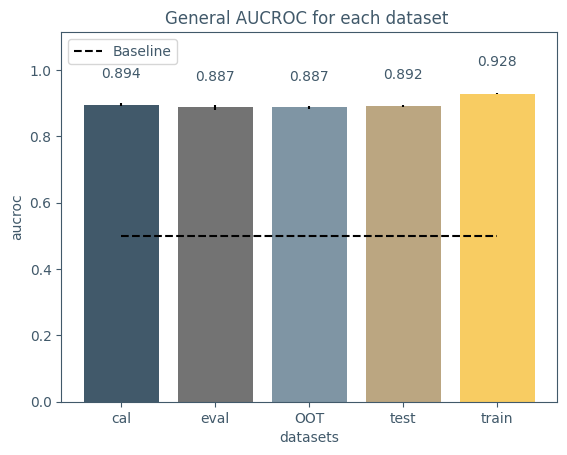

In [5]:
m = understanding_model.plot_general_metrics(metrics, 'aucroc', baseline=0.5)

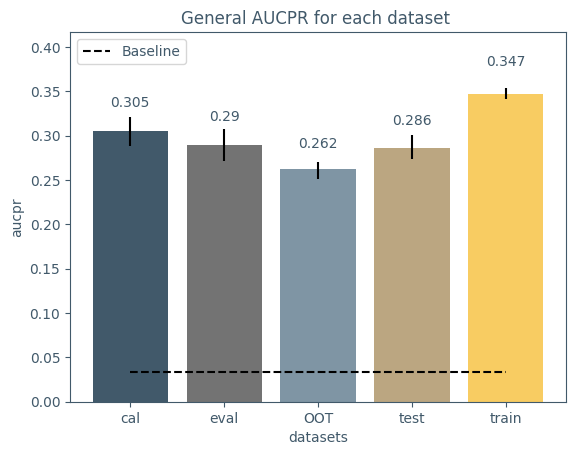

In [6]:
m = understanding_model.plot_general_metrics(metrics, 'aucpr', baseline=aucpr_baseline)

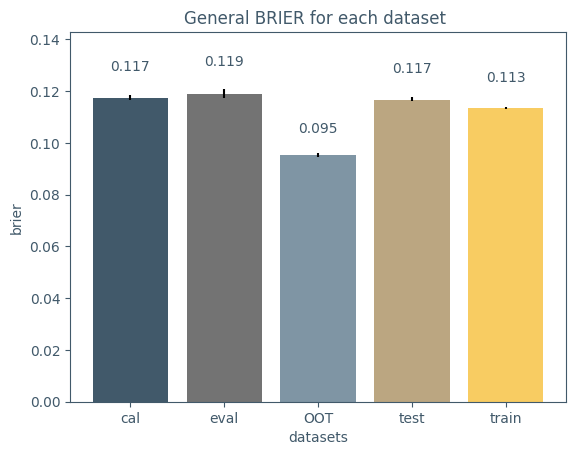

In [7]:
m = understanding_model.plot_general_metrics(metrics, 'brier', baseline=None)

In [8]:
grouped_info_metrics = understanding_model.generate_grouped_info_metrics(info, months=6)

Loading file from /mnt/c/Users/52333/Documents/projects/dynamic-rythms/src/../data/temp_results/grouped_info_metrics.parquet


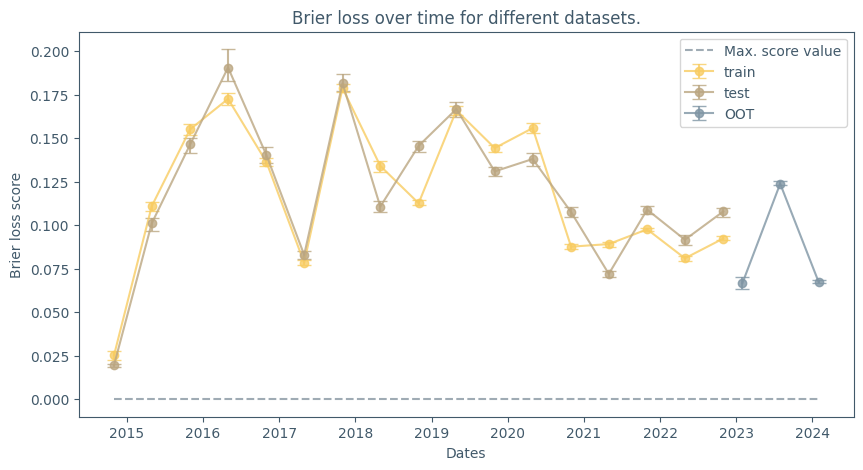

In [9]:
understanding_model.plotting__brier_loss_score(grouped_info_metrics)

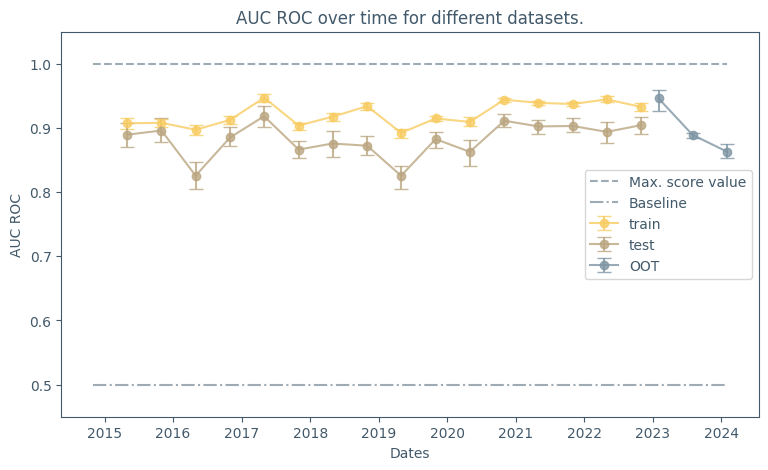

In [10]:
understanding_model.plotting__auc_roc(grouped_info_metrics)

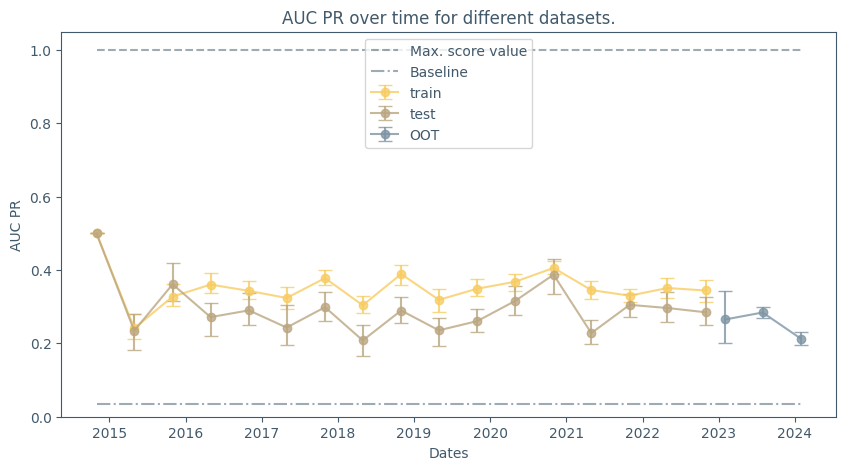

In [11]:
understanding_model.plotting__auc_pr(grouped_info_metrics, baseline=aucpr_baseline)

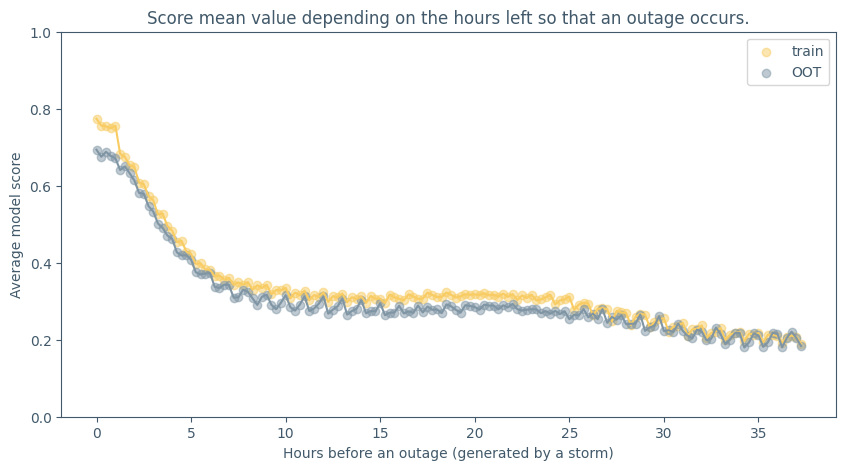

In [12]:
understanding_model.plotting_score_hours_before_outage(info)

### Explanation

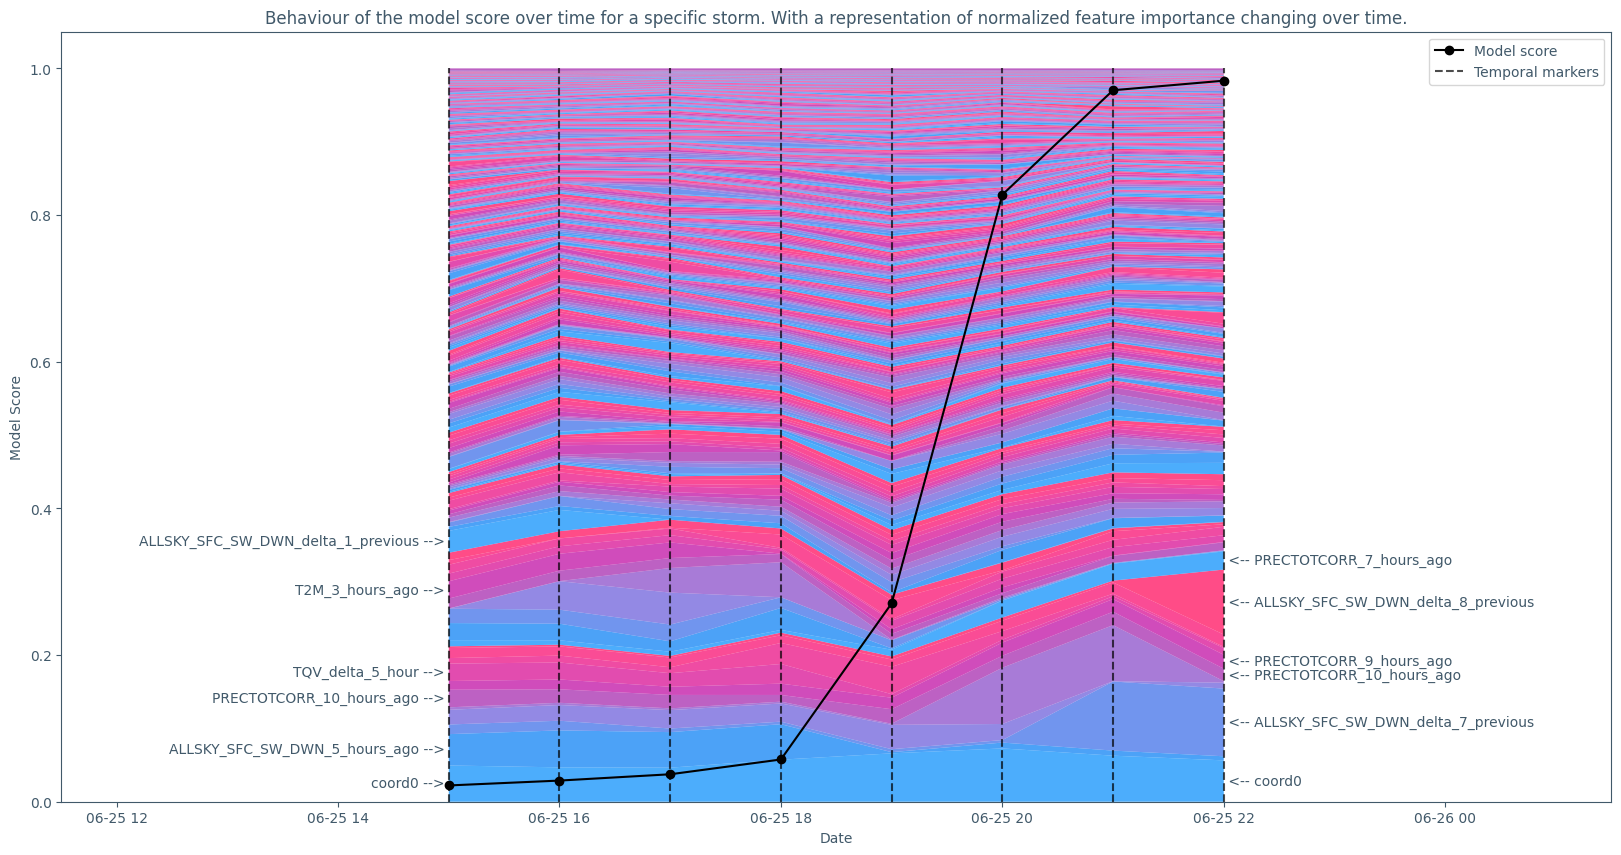

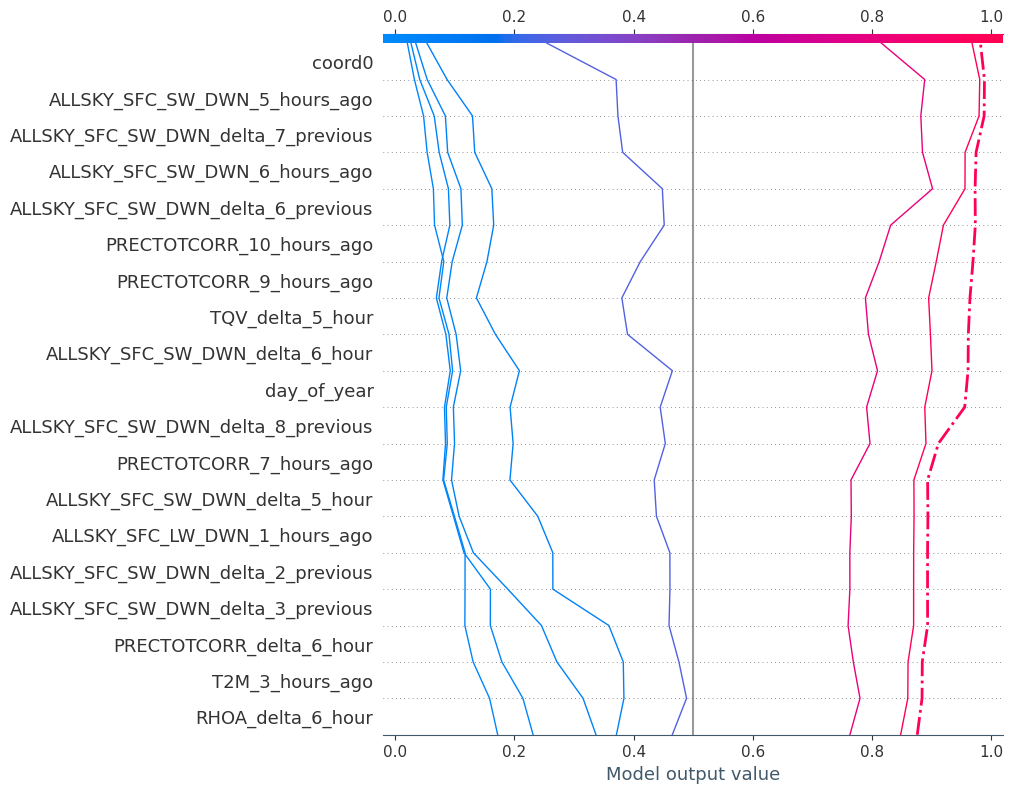

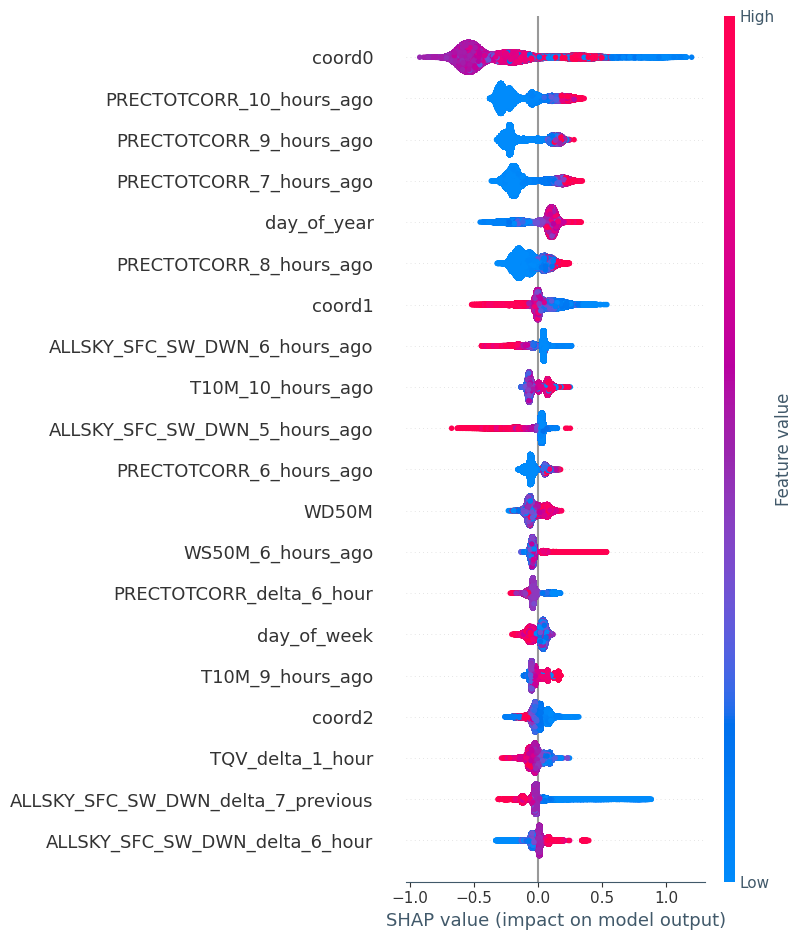

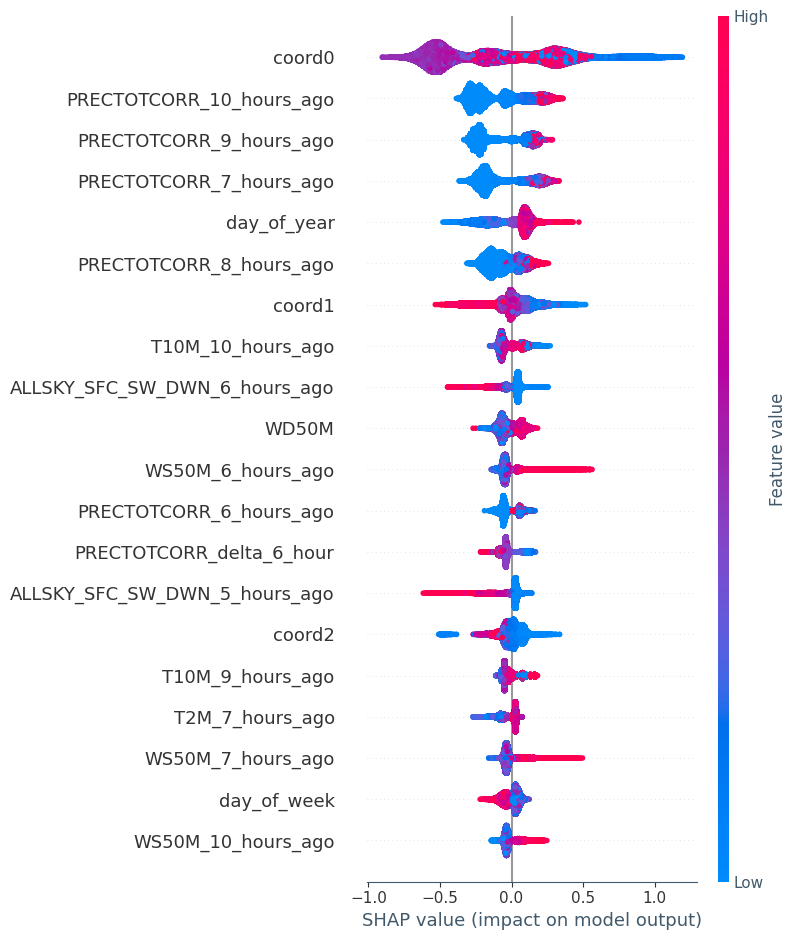

In [4]:
understanding_model.shap_importance_for_each_sample(x, info)

### Uncertainty quantification